In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy import stats
from locustvr_converter import preprocess_matrex_data

##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file

#### Session 0.1: Introducing helper functions for plotting.

In [2]:
#https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

#### Session 0.2: Load analysis methods in python dictionary form

In [3]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
thisDataset ="D:/MatrexVR_grass1_Data/RunData"
#parameter name means independent variable in the experiment
parameter_name='mu'
#parameter_name='agent_speed'
analysis_window=analysis_methods.get("analysis_window")
monitor_fps=analysis_methods.get("monitor_fps")
analysis_window=[-20,20]

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [4]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",parameter_name)
        animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",parameter_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values

    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

### Session 1.1: introduce helper functions to make plot and calculate speed

In [5]:
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
colormap_name = "viridis"

In [29]:
def calculate_speed_ang_speed(dif_x,dif_y,ts,number_frame_scene_changing=5):
    heading_direction = np.arctan2(dif_y,dif_x)
    heading_direction[0:number_frame_scene_changing]=np.nan
    ang_deg = np.rad2deg(heading_direction) ## if converting the unit to degree
    ang_deg = np.mod(ang_deg,360.)
    ang_deg1=np.insert(ang_deg, 0, 0)
    angular_velocity=np.diff(ang_deg1)/np.diff(ts)
    focal_distance_fbf=np.sqrt(np.sum([dif_x**2,dif_y**2],axis=0))
    focal_distance_fbf[0:number_frame_scene_changing]=np.nan
    instant_speed=focal_distance_fbf/np.diff(ts)
    return instant_speed,angular_velocity

In [7]:
def trajectory_analysis(df_XY):
    trajec_lim=150
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(18, 14), tight_layout=True
    )
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    #plt.rcParams['font.family'] = 'Helvetica'
    cmap = plt.get_cmap('viridis')
    ax1, ax2, ax3, ax4 = axes.flatten()
    ax1.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='ISI'
    )
    ax2.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='Direction 0'
    )
    ax3.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='Direction 45'
    )
    ax4.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='Direction 315'
    )      
    for key, grp in df_XY.groupby('fname'):
        if grp['type'][0]=='empty_trial':
            ax1.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
        else:
            if grp['mu'][0]==0:
                ax2.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            elif grp['mu'][0]==45:
                ax3.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            elif grp['mu'][0]==315:
                ax4.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            else:
                print("unexpected direction")
    ax2.plot(df_agent.loc[df_agent['mu'] == 0]['X'].values,df_agent.loc[df_agent['mu'] == 0]['Y'].values,color='k')
    ax3.plot(df_agent.loc[df_agent['mu'] == 45]['X'].values,df_agent.loc[df_agent['mu'] == 45]['Y'].values,color='k')
    ax4.plot(df_agent.loc[df_agent['mu'] == 315]['X'].values,df_agent.loc[df_agent['mu'] == 315]['Y'].values,color='k')

    #plt.savefig(fig_name)
    plt.show()

In [8]:
def time_series_plot(target_distance,instant_speed,angles,analysis_window):
    fig, axes = plt.subplots(
        nrows=3, ncols=1, figsize=(9, 7), tight_layout=True
    )
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    cmap = plt.get_cmap('viridis')
    ax1, ax2, ax3= axes.flatten()
    ax1.set(
        title='Distance'
    )
    ax2.set(
        title='Instant Speed'
    )
    ax3.set(
        # yticks=[0,90,180],
        #ylim=(-np.pi-0.1, np.pi+0.1),
        # ylim=(-5, 185),
        title='angular deviation'
    )
    # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    # ax3.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
    # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax1.plot(np.arange(target_distance.shape[0]),target_distance)
    ax2.plot(np.arange(instant_speed.shape[0]),instant_speed)
    ax3.plot(np.arange(angles.shape[0]),angles)
    plt.show()

### Section 2.0: Pool animal's response together according to some criteria (from none criteria to criteria that can define the follow behaviour)
Output1: a list 'follow_proportion_across_animals' showing the proportion of 'follow' time for each animal (across trials)

Output2: a list 'relative_pos_all_animals' showing relative position between virtual and focal locusts across time. 1st and 2nd columns shown relative x and y, 3rd columns shown virtual animal's moving direction. 4th column shown the timestamp

In [21]:
analysis_methods.update({"plotting_trajectory": False})

In [ ]:
trajec_lim=150
max_target_distance=50
number_frame_scene_changing=5
extract_follow_epoches=True
relative_pos_all_animals=[]
trial_evaluation_across_animals=[]
follow_proportion_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        print(f'no such a dir exist {this_dir}')
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), agent_pattern)
    df_agent = pd.read_hdf(found_result)
    found_result = find_file(Path(this_dir), xy_pattern)
    df_XY = pd.read_hdf(found_result)
    df_agent['this_vr']=this_vr
    df_agent['fname']=df_agent['fname'].astype(str) + '_' + df_agent['this_vr'].astype(str)   
    df_XY['this_vr']=this_vr
    df_XY['fname']=df_XY['fname'].astype(str) + '_' + df_XY['this_vr'].astype(str)
    if analysis_methods.get("plotting_trajectory"):
        trajectory_analysis(df_XY)
    dif_across_trials=[]
    follow_epochs_across_trials=np.ones((len(df_agent['fname'].unique()),1))
    total_epochs_across_trials=np.ones((len(df_agent['fname'].unique()),1))
    trial_evaluation_list=[]
    trial_id=0
    for key, grp in df_XY.groupby('fname'):
        if grp['type'][0]=='empty_trial':
            focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
            dif_x=np.diff(focal_xy[0])
            dif_y=np.diff(focal_xy[1])
            #distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
            ts=grp["ts"].to_numpy()
            instant_speed,angular_velocity= calculate_speed_ang_speed(dif_x,dif_y,ts)
            turn_degree_ISI=angular_velocity*np.diff(ts)
            focal_distance_ISI=instant_speed*np.diff(ts)
            pre_stim_ISI=grp['duration'][0]
            continue
        else:
            #print(f"stimulus degree: {grp['mu'][0]}")
            focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
            dif_x=np.diff(focal_xy[0])
            dif_y=np.diff(focal_xy[1])
            distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
            ts=grp["ts"].to_numpy()
            instant_speed,angular_velocity= calculate_speed_ang_speed(dif_x,dif_y,ts)
            turn_degree_fbf=angular_velocity*np.diff(ts)
            focal_distance_fbf=instant_speed*np.diff(ts)
            agent_xy=np.vstack((df_agent[df_agent['fname']==key]["X"].to_numpy(),df_agent[df_agent['fname']==key]["Y"].to_numpy()))
            agent_distance_fbf=np.sqrt(np.sum([np.diff(agent_xy)[0]**2,np.diff(agent_xy)[1]**2],axis=0))
            vector_dif=agent_xy-focal_xy
            theta = np.radians(grp['mu'][0]-360)  
            rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])# calculate the rotation matrix to align the agent to move along the same direction
            vector_dif_rotated=rot_matrix @ vector_dif
            target_distance=LA.norm(vector_dif, axis=0)
            dot_product=np.diag(np.matmul(np.transpose(np.diff(focal_xy)),np.diff(agent_xy)))
            angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
            angles_in_degree= angles*180/np.pi
            if analysis_methods.get("plotting_trajectory"):
                time_series_plot(target_distance,instant_speed,angles_in_degree,analysis_window)

            follow_sercan=np.logical_and(target_distance[1:]<max_target_distance, instant_speed>1,angles_in_degree<10)
            if extract_follow_epoches:
                #epochs_of_interest=np.logical_and(target_distance[1:]<max_target_distance, instant_speed>1)#a condition before fixing angles
                epochs_of_interest=follow_sercan
            else:
                epochs_of_interest=np.ones((instant_speed.shape[0]))==1.0#created a all-true array
            

            vector_dif_rotated=vector_dif_rotated[:,1:]
            degree_in_the_trial=np.repeat(grp['mu'][0],np.transpose(grp['ts'].values).shape[0])
            degree_time=np.vstack((degree_in_the_trial,grp['ts'].values))
            degree_time=degree_time[:,1:]
            follow_wrap=np.concat((vector_dif_rotated[:,epochs_of_interest],degree_time[:,epochs_of_interest]))
            dif_across_trials.append(pd.DataFrame(np.transpose(follow_wrap)))
            ###wrap up some raw data

            # number_frames=angles_in_degree.shape[0]
            # con_matrex=(trial_id,grp['mu'][0],grp['polar_angle'][0],grp['this_vr'][0],sum(follow_sercan),number_frames,sum(focal_distance_fbf),sum(turn_degree_fbf),sum(focal_distance_ISI),sum(turn_degree_ISI),grp['duration'][0],pre_stim_ISI,grp['temperature'][0],grp['humidity'][0])
            # trial_evaluation=np.concat(con_matrex)

            df_summary = pd.DataFrame(
                {
                    "trial_id": [trial_id],
                    "mu": [grp['mu'][0]],
                    "polar_angle": [grp['polar_angle'][0]],
                    "this_vr": [grp['this_vr'][0]],
                    "num_follow_epochs": [sum(follow_sercan)],
                    "number_frames": [grp.shape[0]-1],
                    "travel_distance": [np.nansum(focal_distance_fbf)],
                    "turning_distance": [np.nansum(turn_degree_fbf)],
                    "travel_distance_ISI": [np.nansum(focal_distance_ISI)],
                    "turning_distance_ISI": [np.nansum(turn_degree_ISI)],
                    "duration": [grp['duration'][0]],
                    "duration_ISI": [pre_stim_ISI],
                    "temperature": [grp['temperature'][0]],
                    "humidity": [grp['humidity'][0]],
                }
            )
            trial_evaluation_list.append(df_summary)
            # id_time=np.vstack((np.repeat(trial_id,np.transpose(grp['ts'].values).shape[0]),grp['ts'].values))
            # con_matrex=(focal_xy,agent_xy,id_time)
            # raw_data=np.concat(con_matrex)
            # raw_data_list.append(pd.DataFrame(np.transpose(raw_data)))
            trial_id=trial_id+1
    tmp=pd.concat(dif_across_trials)
    if tmp.shape[1]==2:
        tmp.columns = ['x', 'y']
    elif tmp.shape[1]==4:
        tmp.columns = ['x', 'y','degree','ts']
        
    #fig, ax = plt.subplots(dpi=300, figsize=(2,2))
    #plt.hist2d(tmp['x'].values,tmp['y'].values)
    #fig, ax = plt.subplots(dpi=300, figsize=(2,2))
    #sns.histplot(tmp,x='x',y='y')
    #plt.show()

    #follow_proportion_across_animals.append(sum(follow_epochs_across_trials)[0]/sum(total_epochs_across_trials)[0])
    #follow_proportion_across_animals.append(sum(follow_epochs_across_trials)[0]/sum(total_epochs_across_trials)[0])
    relative_pos_all_animals.append(tmp)
    trial_evaluation=pd.concat(trial_evaluation_list)
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    # r_tmp.columns=['focal_x','focal_y','agent_x','agent_y','trial_id','ts']
    trial_evaluation_across_animals.append(trial_evaluation)
    animal_id=animal_id+1

#### Section 2.1: Using 1D histogram to plot proportion of time and 2D histogram to plot relative position

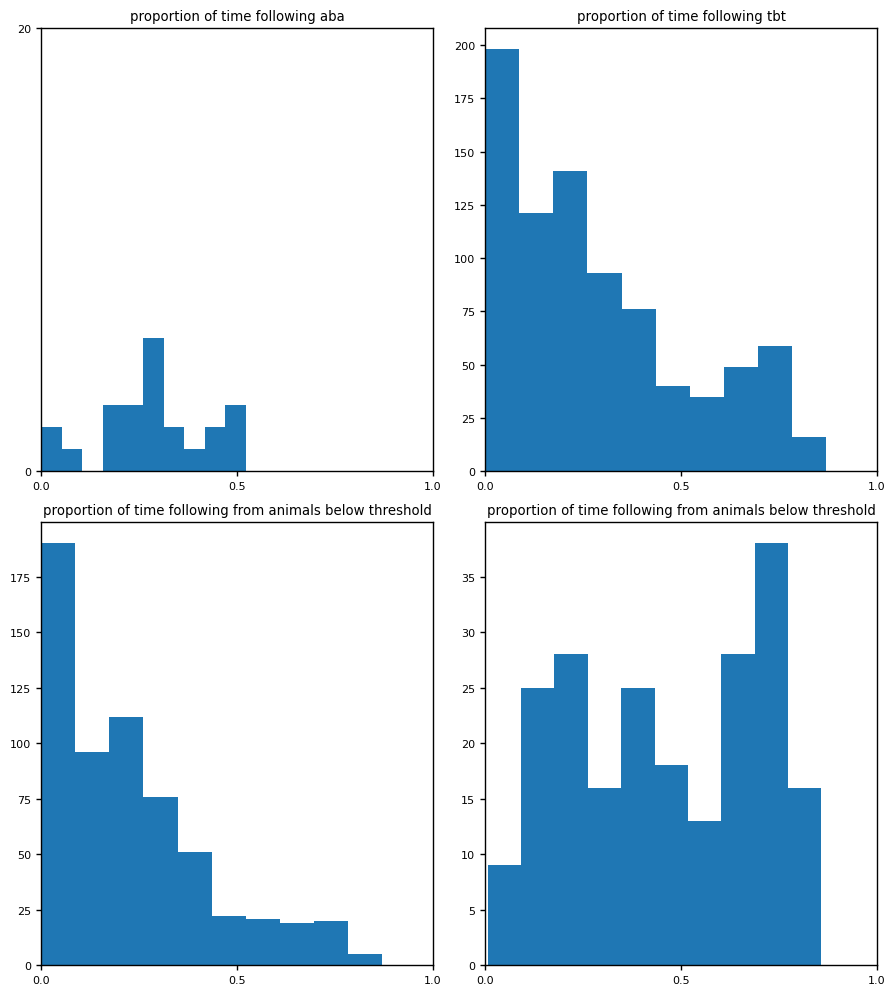

In [183]:
good_follower_threshold=0.4
all_evaluation=pd.concat(trial_evaluation_across_animals)
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.hist(all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum())
ax1.set(xticks=[0,0.5,1],xlim=(0,1),yticks=[0,20],ylim=(0,20),title='proportion of time following aba')
ax2.hist(all_evaluation['num_follow_epochs']/all_evaluation['number_frames'])
ax2.set(xticks=[0,0.5,1],xlim=(0,1),title='proportion of time following tbt')
follower_of_interest=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()<good_follower_threshold
row_of_interest=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
ax3.hist(all_evaluation[row_of_interest.values]['num_follow_epochs']/all_evaluation[row_of_interest.values]['number_frames'])
ax3.set(xticks=[0,0.5,1],xlim=(0,1),title='proportion of time following from animals below threshold')
follower_of_interest=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()>good_follower_threshold
row_of_interest=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
ax4.hist(all_evaluation[row_of_interest.values]['num_follow_epochs']/all_evaluation[row_of_interest.values]['number_frames'])
ax4.set(xticks=[0,0.5,1],xlim=(0,1),title='proportion of time following from animals below threshold')
plt.show()

In [ ]:
all_trials=pd.concat(relative_pos_all_animals)
fig, axes = plt.subplots(nrows=1, ncols=len(all_trials["degree"].unique()),tight_layout=True,sharex=True, sharey=True)
i=0
for key, grp in all_trials.groupby('degree'):
    print(f"stimulus degree: {key}")
    axes[i].hist2d(grp['x'].values,grp['y'].values,bins=400)
    axes[i].set(adjustable='box', aspect='equal')
    axes[i].set(
    yticks=[-40,0,40],
    xticks=[-20,0,20,40],
    xlim=(-20,100),ylim=(-45, 45))
    i=i+1
plt.show()

In [ ]:
##plot potential follow response in 2D histogram
all_trials=pd.concat(relative_pos_all_animals)
fig, ax = plt.subplots(dpi=300, figsize=(2,2))
plt.hist2d(all_trials['x'].values,all_trials['y'].values,bins=36)
fig, ax = plt.subplots(dpi=300, figsize=(2,2))
sns.histplot(all_trials,x='x',y='y')
plt.show()

#### Section 2.2: save data into Mat file if needed

In [ ]:
##save the raw data into mat file for matlab
from scipy.io import savemat
all_raw=pd.concat(relative_pos_all_animals)
#all_raw['trial_id']=all_raw['trial_id'].astype(int)
data_dict = {name: col.values for name, col in all_raw.items()}
summary_file_name = Path(thisDataset) /"time_series_curated.mat"
savemat(summary_file_name, data_dict)

### Section 3.0, analysis walking behavours before and after the presence of stimulus

In [223]:
def fix_format(all_trials):

    all_trials['id'] = all_trials['id'].astype(int)
    all_trials['mu'] = all_trials['mu'].astype(int)
    all_trials['velocity'] = all_trials['velocity'].astype(float)
    all_trials['omega'] = all_trials['omega'].astype(float)
    all_trials['normalised_v'] = all_trials['normalised_v'].astype(float)
    all_trials['normalised_omega'] = all_trials['normalised_omega'].astype(float)
    if 'density' in all_trials.columns:
        all_trials['density'] = all_trials['density'].astype(int)
    return all_trials

In [ ]:
trajec_lim=150
good_follower_only=False
duration_for_baseline=3
align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
number_frame_scene_changing=12
dif_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        continue
    if good_follower_only:
        if (follow_proportion_across_animals[animal_id]>0.4) and (follow_proportion_across_animals[animal_id]<0.2):
        #if follow_proportion_across_animals[animal_id]<0.4:
            animal_id+=1
            continue

    agent_pattern = f"VR{this_vr}*agent_full.h5"
    found_result = find_file(Path(this_dir), agent_pattern)
    if found_result is not None:
        df_agent = pd.read_hdf(found_result)
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), xy_pattern)
    if found_result is None:
        continue
    df_XY = pd.read_hdf(found_result)
    df_XY['this_vr']=this_vr
    df_XY['fname']=df_XY['fname'].astype(str) + '_' + df_XY['this_vr'].astype(str)
    #trajectory_analysis(df_XY)
    dif_across_trials=[]
    if 'basedline_v' in locals():
        del basedline_v
    trial_id=0
    for key, grp in df_XY.groupby('fname'):
        focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
        distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
        ts=grp["ts"].to_numpy()
        dif_x=np.diff(focal_xy[0])
        dif_y=np.diff(focal_xy[1])
        instant_speed,_=calculate_speed_ang_speed(dif_x,dif_y,ts)
        angles = np.degrees(np.arctan2(dif_y, dif_x)) ## return angles in degree, between -180 and 180
        angles[0:number_frame_scene_changing]=np.nan
        angular_speed=angles/np.diff(ts)
        #time_series_plot(distance_from_centre,instant_speed,angular_speed,frame_range)
        if 'type' in df_XY.columns:
            if align_with_isi_onset:
                if grp['type'][0]=='empty_trial':
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                else:
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
            else:
                if grp['type'][0]=='empty_trial':
                    print('ISI now')
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
                    basedline_v=np.mean(v_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    basedline_w=np.mean(w_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_w=np.repeat(np.nan,w_of_interest.shape[0])

                else:
                    print('stim now')
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                    if 'basedline_v' in locals():
                        normalised_v=v_of_interest/basedline_v
                    else:
                        normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    if 'basedline_w' in locals():
                        normalised_w=w_of_interest/basedline_w
                    else:
                        normalised_w=np.repeat(np.nan,w_of_interest.shape[0])

        else:
            if align_with_isi_onset:
                if grp['density'][0]==0.0:
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                    if 'basedline_v' in locals():
                        normalised_v=v_of_interest/basedline_v
                    else:
                        normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    if 'basedline_w' in locals():
                        normalised_w=w_of_interest/basedline_w
                    else:
                        normalised_w=np.repeat(np.nan,w_of_interest.shape[0])
                else:
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
                    basedline_v=np.mean(v_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    basedline_w=np.mean(w_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_w=np.repeat(np.nan,w_of_interest.shape[0])

            else:
                if grp['density'][0]==0.0:
                    print('ISI now')
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]

                else:
                    print('Stim now')
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]


        if 'type' in df_XY.columns:
            con_matrex=(d_of_interest,v_of_interest,w_of_interest,normalised_v,normalised_w,np.repeat(trial_id,v_of_interest.shape[0]),np.repeat(grp['mu'][0],v_of_interest.shape[0]),np.repeat(grp['type'][0],v_of_interest.shape[0]))
        else:
            con_matrex=(d_of_interest,v_of_interest,w_of_interest,normalised_v,normalised_w,np.repeat(trial_id,v_of_interest.shape[0]),np.repeat(grp['mu'][0],v_of_interest.shape[0]),np.repeat(grp['density'][0],v_of_interest.shape[0]))
        raw_data=np.vstack(con_matrex)
        dif_across_trials.append(pd.DataFrame(np.transpose(raw_data)))
        trial_id += 1
    tmp=pd.concat(dif_across_trials)
    if 'type' in df_XY.columns:
        tmp.columns = ['distance_from_centre', 'velocity','omega','normalised_v','normalised_omega','id','mu','object']
    else:
        tmp.columns = ['distance_from_centre', 'velocity','omega','normalised_v','normalised_omega','id','mu','density']
    tmp.insert(0, 'animal_id', np.repeat(animal_id,tmp.shape[0]))
    dif_across_animals.append(tmp)
    animal_id += 1

In [224]:
if type(dif_across_animals)==list:
    all_trials=pd.concat(dif_across_animals)
    all_trials=fix_format(all_trials)
else:
    all_trials=fix_format(dif_across_animals)

In [230]:
def check_baseline_distribution(all_trials,analysis_methods,metrics_name='velocity'):
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
    these_baselines=[]
    for keys, this_data in all_trials.groupby(['animal_id','id']):
        #print(this_data['object'][1])
        if align_with_isi_onset:
            if this_data['object'][1]!='empty_trial':
            #if keys[1]%2==0:#for the Swarm scene to only use stim trials to get the baseline
                this_speed=this_data[metrics_name].values
                #print(this_speed)
                these_baselines.append(np.mean(this_speed[-duration_for_baseline*monitor_fps:]))
        
        else:
            if this_data['object'][1]=='empty_trial':
            #if keys[1]%2!=0:#for the Swarm scene to only use ISI trials
                this_speed=this_data[metrics_name].values
                these_baselines.append(np.mean(this_speed[-duration_for_baseline*monitor_fps:]))
    plt.hist(np.vstack(these_baselines),bins=200)
    plt.minorticks_on()
    plt.show()

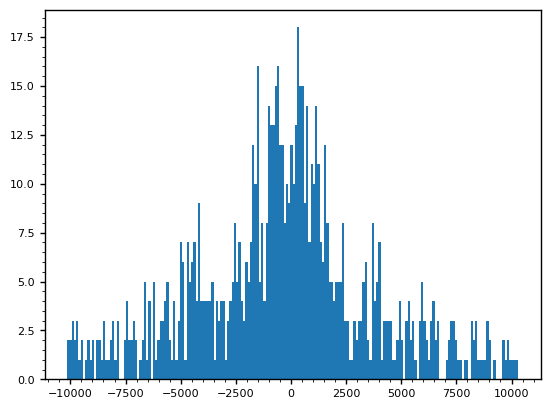

In [231]:
metrics_name='omega'
check_baseline_distribution(all_trials,analysis_methods,metrics_name='omega')

In [232]:
def split_trials(all_trials,metrics_name='velocity',metrics_name2='normalised_v',walk_threshold=1):
    walk_trials_boo=[]
    these_speed=[]
    these_normalised_speed=[]
    for keys, this_data in all_trials.groupby(['animal_id','id']):
        this_speed=this_data[metrics_name].values
        baseline_speed=np.mean(this_speed[-duration_for_baseline*monitor_fps:])
        walk_trials_boo.append(abs(baseline_speed)>walk_threshold)
        these_speed.append(this_speed)
        these_normalised_speed.append(this_data[metrics_name2].values)
    return walk_trials_boo,these_speed,these_normalised_speed

In [233]:
metrics_name='omega'
Is_move_trials,these_metrics,these_normalised_metrics=split_trials(all_trials,'omega','normalised_omega',2500)

In [258]:
Is_move_trials,these_metrics,these_normalised_metrics=split_trials(all_trials)

In [234]:
def extract_trial_index(walk_trials_boo,analysis_methods):
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
#int((trial_id)/2) means the number of stimulus trial
    after_walk_ith_trial=[]
    after_stationary_ith_trial=[]
    if align_with_isi_onset:
        after_walk_ith_trial=[i+1 for i, x in enumerate(walk_trials_boo[1::2]) if x and i % int((trial_id)/2) != (trial_id)/2-1]
        after_stationary_ith_trial=[i+1 for i, x in enumerate(walk_trials_boo[1::2]) if x==False and i % int((trial_id)/2) != (trial_id)/2-1]
    else:
        after_walk_ith_trial=[i for i, x in enumerate(walk_trials_boo[::2]) if x]
        after_stationary_ith_trial=[i for i, x in enumerate(walk_trials_boo[::2]) if x==False]
    return after_walk_ith_trial,after_stationary_ith_trial


In [259]:
after_move_ith_trial,after_stationary_ith_trial=extract_trial_index(Is_move_trials,analysis_methods)

In [301]:
def get_fill_between_range(p1,mean_p1):
    sem_response = np.std(p1, axis=0, ddof=1) / np.sqrt(p1.shape[0])
    dif_y1=mean_p1 + sem_response
    dif_y2=mean_p1 - sem_response
    return dif_y1,dif_y2

In [308]:
def plot_visual_evoked_behaviour(these_speed,these_normalised_speed,after_move_ith_trial,after_stationary_ith_trial,analysis_methods,metrics_name='velocity',row_of_interest=None):

    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
    good_follower_only=True
    tmp=np.vstack(these_speed)
    tmp1=np.vstack(these_normalised_speed)
    if align_with_isi_onset:
       stim_speed=tmp[::2]
       stim_norm_speed=tmp1[::2]
    else:
       stim_speed=tmp[1::2]
       stim_norm_speed=tmp1[1::2]

    fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(9,10), tight_layout=True
        )
    ax1, ax2, ax3, ax4 = axes.flatten()
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['axes.linewidth'] = 1
    cmap = plt.get_cmap('viridis')
    if good_follower_only and type(row_of_interest)==pd.Series:
        row_and_stationary=[]
        row_and_walk=[]
        for i in np.where(row_of_interest)[0].tolist():
            if i in after_stationary_ith_trial:
                row_and_stationary.append(i)
            else:
                row_and_walk.append(i)
        p1=stim_speed[row_and_stationary,:]
        p2=stim_norm_speed[row_and_stationary,:]
        p3=stim_speed[row_and_walk,:]
        p4=stim_norm_speed[row_and_walk,:]

    else:
        p1=stim_speed[after_stationary_ith_trial,:]
        p2=stim_norm_speed[after_stationary_ith_trial,:]
        p3=stim_speed[after_move_ith_trial,:]
        p4=stim_norm_speed[after_move_ith_trial,:]
        
    x=np.arange(0,p1.shape[1])
    ax1.plot(np.transpose(p1),linewidth=0.1)
    mean_p1=np.mean(p1,axis=0)
    ax1.plot(mean_p1,'k',linewidth=1)
    dif_y1,dif_y2=get_fill_between_range(p1,mean_p1)
    ax1.fill_between(x,dif_y1,dif_y2, alpha=1,color='k')
    #ax1.plot(np.median(p1,axis=0),'k--',linewidth=0.5)
    mean_p2=np.mean(p2,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p2,mean_p2)
    ax2.plot(np.transpose(p2),linewidth=0.1)
    ax2.plot(np.mean(p2,axis=0),'k',linewidth=1)
    ax2.fill_between(x,dif_y1,dif_y2, alpha=1,color='k')
    #ax2.plot(np.median(p2,axis=0),'k--',linewidth=0.5)
    mean_p3=np.mean(p3,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p3,mean_p3)
    ax3.plot(np.transpose(p3),linewidth=0.1)
    ax3.plot(np.mean(p3,axis=0),'k',linewidth=1)
    ax3.fill_between(x,dif_y1,dif_y2, alpha=1,color='k')
    #ax3.plot(np.median(p3,axis=0),'k--',linewidth=0.5)
    mean_p4=np.mean(p4,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p4,mean_p4)
    ax4.plot(np.transpose(p4),linewidth=0.1)
    ax4.plot(np.mean(p4,axis=0),'k',linewidth=1)
    ax4.fill_between(x,dif_y1,dif_y2,alpha=1,color='k')
    #ax4.plot(np.median(p4,axis=0),'k--',linewidth=0.5)
    if metrics_name=='velocity':
        ylimit_log=100
        ax1.set_ylim([0,50])
        ax3.set_ylim([0,50])
    else:
        ylimit_log=1000
        ax1.set_ylim([-10*ylimit_log,10*ylimit_log])
        ax3.set_ylim([-10*ylimit_log,10*ylimit_log])


    ax1.set(
        ylabel=metrics_name,
        xlabel="frame",
    )
    ax2.set(
        ylabel="normalised values (ratio)",
        xlabel="frame",
        ylim=[1/ylimit_log,ylimit_log],
    )
    ax3.set(
        ylabel=metrics_name,
        xlabel="frame",
    )
    ax4.set(
        ylabel="normalised values (ratio)",
        xlabel="frame",
        ylim=[1/ylimit_log,ylimit_log],
    )
    ax2.set_yscale('log')
    ax4.set_yscale('log')
    plt.show()

In [ ]:
plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_move_ith_trial,after_stationary_ith_trial,analysis_methods,'velocity',row_of_interest)